In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
import random
import gc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder
from imblearn.under_sampling import RandomUnderSampler

# Import libraries for Hypertuning
import optuna

# Import libraries for gradient boosting
import xgboost as xgb
import lightgbm as lgb
import xgboost as xgb
import lightgbm as lgb 
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

from sklearn.feature_selection import RFE, RFECV
from sklearn.inspection import permutation_importance

# Useful line of code to set the display option so we could see all the columns in pd dataframe
pd.set_option('display.max_columns', None)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# <h1 style = "font-family: Georgia;font-weight: bold; font-size: 30px; color: #1192AA; text-align:left">Load Data</h1>

In [2]:
filepath = '/kaggle/input/icr-identify-age-related-conditions/'
df_train = pd.read_csv(os.path.join(filepath, 'train.csv'), index_col=[0])
df_test = pd.read_csv(os.path.join(filepath, 'test.csv'), index_col=[0])
greeks = pd.read_csv(f'{filepath}greeks.csv')

target_col = 'Class'

# df_train['EJ'].replace({'A':0, 'B':1}, inplace=True)
# df_test['EJ'].replace({'A':0, 'B':1}, inplace=True)

df_train = df_train.drop(['EJ'], axis=1)
df_test = df_test.drop(['EJ'], axis=1)

df_train = df_train.rename(columns={'BD ': 'BD', 'CD ': 'CD', 'CW ': 'CW', 'FD ': 'FD'})
df_test = df_test.rename(columns={'BD ': 'BD', 'CD ': 'CD', 'CW ': 'CW', 'FD ': 'FD'})

print(f'df_train shape: {df_train.shape}\n')
print(f'df_test shape: {df_test.shape}\n')

df_train shape: (617, 56)

df_test shape: (5, 55)



In [3]:
df_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,51.618996,78.526968,65.821872,29.708112,0.296850,17167.209610,9.879296,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,27.1887,285.628059,344.644105,505.006814,257.432377,61.910576,0.772304,85.233928,6.682597,0.038208,1.050225,0.761025,39.852923,

In [4]:
# Only include numerical features
df_train_numerical = df_train.drop(['Class'], axis=1)

In [5]:
# Initialize the KNNImputer with the desired number of neighbors
imputer = KNNImputer(n_neighbors=5)

# Perform KNN imputation
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train[df_train_numerical.columns]), columns=df_train_numerical.columns)
df_test_imputed =pd.DataFrame(imputer.transform(df_test[df_train_numerical.columns]), columns=df_train_numerical.columns)

In [6]:
# Check if there are still missing values in the train and test data sets
df_train_null = df_train_imputed[df_train_imputed.isnull().any(axis=1)]
df_test_null = df_test_imputed[df_test_imputed.isnull().any(axis=1)]

# Display the rows with null values
print('No. of records with missing value in Train data set after Imputation : {}'.format(df_train_null.shape[0]))
print('No. of records with missing value in Test data set after Imputation : {}'.format(df_test_null.shape[0]))

print('=' * 50)

# Replace the imputed columns in the train data sets
df_train_2 = df_train.drop(df_train_numerical.columns, axis=1).reset_index()
df_train_2 = pd.concat([df_train_2, df_train_imputed], axis=1)

# Replace the imputed columns in the test data sets
df_test_2 = df_test.drop(df_train_numerical.columns, axis=1).reset_index()
df_test_2 = pd.concat([df_test_2, df_test_imputed], axis=1)

X_train = df_train_2.drop([f'{target_col}', 'Id'],axis=1).reset_index(drop=True)
y_train = df_train_2[f'{target_col}'].reset_index(drop=True)
X_test = df_test_2.drop(['Id'],axis=1).reset_index(drop=True)

# Check the shape of the train and test data set 
print('Shape of the Train data set : {}'.format(X_train.shape))
print('Shape of the Test data set : {}'.format(X_test.shape))

X_train.head(5)

No. of records with missing value in Train data set after Imputation : 0
No. of records with missing value in Test data set after Imputation : 0
Shape of the Train data set : (617, 55)
Shape of the Test data set : (5, 55)


,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614


In [7]:
numeric_columns = [_ for _ in X_train.columns if _ not in ['EJ']]

In [8]:
log_cols = [_ for _ in X_train.columns if _ not in ['EJ', 'BN', 'CW', 'EL', 'GL']]
X_train.loc[:, log_cols] = np.log1p(X_train.loc[:, log_cols])
X_test.loc[:, log_cols] = np.log1p(X_test.loc[:, log_cols])

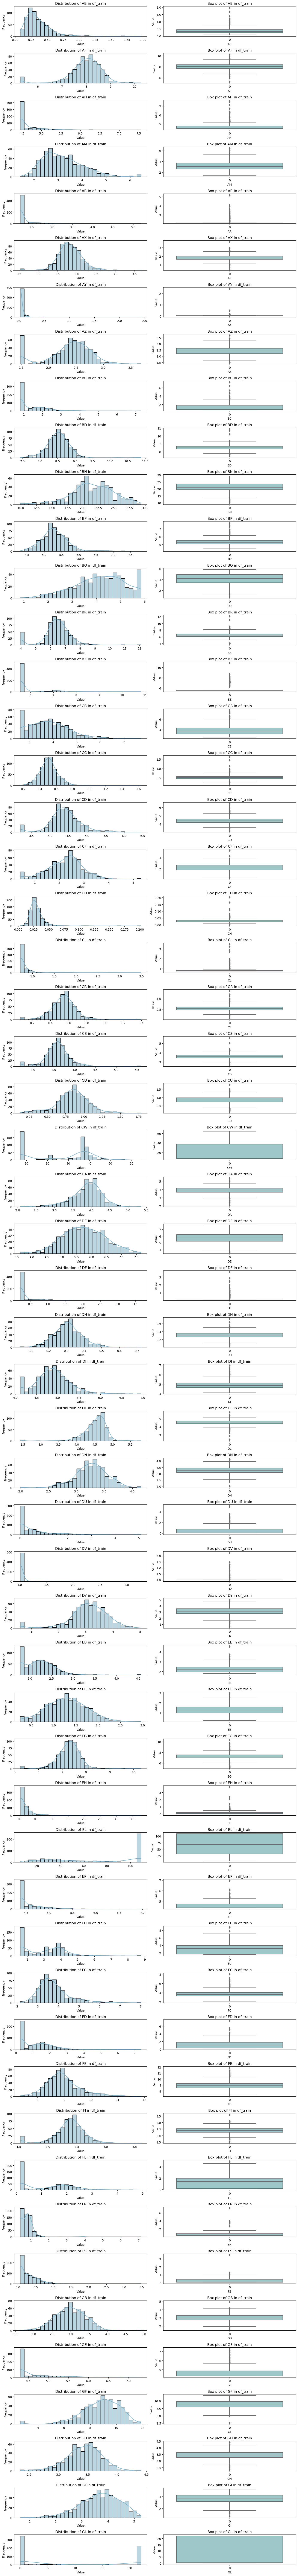

In [9]:
my_palette = sns.cubehelix_palette(n_colors = 7, start=.46, rot=-.45, dark = .2, hue=0.95)
# Create subplots
fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(14, 120))

# Plot the histograms and box plots
for i, column in enumerate(numeric_columns):
    # Histogram
    sns.histplot(X_train[column], bins=30, kde=True, ax=axes[i, 0], color = my_palette[2])
    axes[i, 0].set_title(f'Distribution of {column} in df_train')
    axes[i, 0].set_xlabel('Value')
    axes[i, 0].set_ylabel('Frequency')

    # Box plot
    sns.boxplot(X_train[column], ax=axes[i, 1], color = my_palette[1])
    axes[i, 1].set_title(f'Box plot of {column} in df_train')
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [10]:
sc = StandardScaler() # MinMaxScaler or StandardScaler
X_train[numeric_columns] = sc.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = sc.transform(X_test[numeric_columns])

print(f"X_train shape :{X_train.shape} , y_train shape :{y_train.shape}")
print(f"X_test shape :{X_test.shape}")

# Delete the train and test dataframes to free up memory
del df_train, df_test, df_train_imputed, df_train_2, df_test_2, df_train_null, df_test_null

X_train.head(5)

X_train shape :(617, 55) , y_train shape :(617,)
X_test shape :(5, 55)


,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,-0.793051,0.110642,-0.502595,-0.067111,-0.362049,-3.899745,-0.192844,0.025434,0.687285,-0.598002,0.339209,-0.334638,0.865113,0.332908,-0.444369,0.045541,-0.535320,-2.704642,-0.654541,-0.496871,-0.347128,-3.202882,-2.795074,-0.044267,0.617755,0.893459,-0.070308,-0.399087,-0.728721,-0.923337,-0.191621,0.530490,1.829767,-0.172413,0.125283,-0.308224,-0.440427,-0.024987,1.689726,-1.023528,-0.643980,-1.163649,-1.419323,1.374854,0.207783,-3.120884,0.842595,0.506545,-0.740817,-1.149987,-0.627728,-0.819140,-0.956392,0.751863,-0.814910
1,-1.045391,-1.520469,-0.502595,0.506365,-0.362049,-0.872747,-0.192844,0.735599,-0.682888,0.281949,-0.575174,-0.605475,-1.314327,-2.518775,-0.444369,-0.447719,-0.939986,-1.032230,-0.388691,0.065302,-0.230966,1.388379,-0.634901,0.061040,0.704580,0.950529,-0.770260,-0.399087,0.009254,-0.423330,-0.498191,1.310249,-0.696465,-0.172413,-0.273340,-1.233471,-1.480201,-0.491520,-0.550446,1.088176,-0.058733,0.743895,-1.123003,-0.957190,-0.228882,0.209787,-1.062607,-0.798943,0.589658,-1.585989,-0.627728,0.974516,-0.095903,-0.237662,1.304748
2,0.111391,-0.122825,-0.502595,0.353137,-0.362049,0.674584,-0.192844,0.617694,-0.682888,0.073394,1.456789,-1.034331,1.209578,-0.219872,-0.444369,-0.367553,-0.881464,0.130278,-0.535185,0.400526,-0.347128,-0.086479,0.375089,-0.648287,-0.389911,0.951231,0.046287,-0.399087,-1.457948,-0.231317,-0.914421,0.347247,0.435390,-0.172413,0.756003,-0.141002,2.011492,0.051360,0.518569,1.088176,-0.643980,-0.940911,2.074543,1.218506,0.086357,0.598166,0.889719,-0.199406,1.837757,1.559328,-0.281317,0.487461,-0.218376,-0.122598,-0.807481
3,-0.632149,0.401240,0.370057,1.360629,-0.362049,-0.838296,-0.192844,0.287370,-0.682888,-0.566124,0.644004,0.348374,-1.570782,0.106368,-0.444369,-1.197753,0.201901,0.186093,-1.431043,-0.102893,0.251839,-0.345344,0.509211,-1.333189,-0.385077,0.013515,-0.636615,-0.399087,-0.650296,0.125053,-0.660131,-0.117173,1.078731,-0.172413,1.229563,-0.277898,0.604792,4.366745,1.054583,-1.002074,-0.643980,0.347077,0.400565,1.118736,0.504990,1.432956,0.693762,-0.798943,-0.150092,-0.046034,-0.407454,-0.789113,0.902353,1.085128,-0.811468
4,-0.180474,0.368863,-0.502595,-0.585267,-0.362049,-0.677108,0.073934,-2.142919,4.188900,0.408712,0.745602,1.060361,0.846314,2.396102,-0.444369,0.667426,-0.671753,-0.240218,1.687317,-0.355919,-0.347128,-0.114985,-0.287177,-1.070545,0.495398,1.055571,-0.611639,-0.399087,-1.485803,-0.707104,-1.524672,0.099757,0.345516,-0.172413,-1.108880,-0.289522,0.452843,-0.063151,-0.047822,1.088176,-0.168505,0.727021,-0.482062,0.556290,1.101378,1.147744,0.938089,6.763652,-0.650427,-0.322432,0.591856,0.165792,1.307942,-0.084658,-0.817211


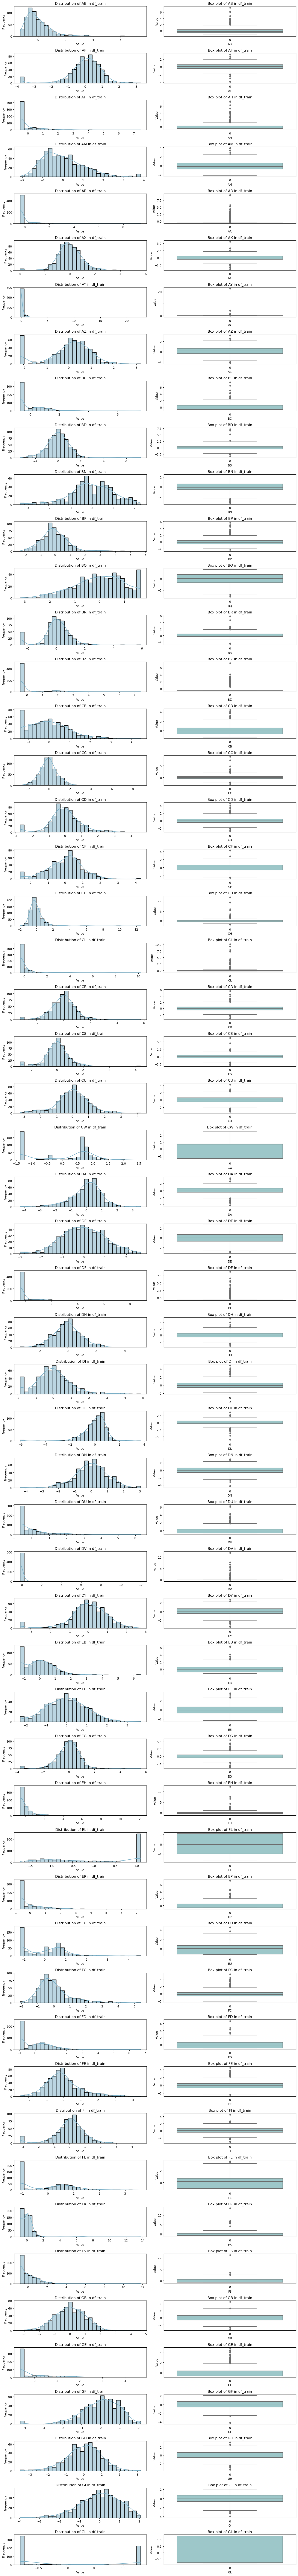

In [11]:
my_palette = sns.cubehelix_palette(n_colors = 7, start=.46, rot=-.45, dark = .2, hue=0.95)
# Create subplots
fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(14, 120))

# Plot the histograms and box plots
for i, column in enumerate(numeric_columns):
    # Histogram
    sns.histplot(X_train[column], bins=30, kde=True, ax=axes[i, 0], color = my_palette[2])
    axes[i, 0].set_title(f'Distribution of {column} in df_train')
    axes[i, 0].set_xlabel('Value')
    axes[i, 0].set_ylabel('Frequency')

    # Box plot
    sns.boxplot(X_train[column], ax=axes[i, 1], color = my_palette[1])
    axes[i, 1].set_title(f'Box plot of {column} in df_train')
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [12]:
X_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,-0.793051,0.110642,-0.502595,-0.067111,-0.362049,-3.899745,-0.192844,0.025434,0.687285,-0.598002,0.339209,-0.334638,0.865113,0.332908,-0.444369,0.045541,-0.535320,-2.704642,-0.654541,-0.496871,-0.347128,-3.202882,-2.795074,-0.044267,0.617755,0.893459,-0.070308,-0.399087,-0.728721,-0.923337,-0.191621,0.530490,1.829767,-0.172413,0.125283,-0.308224,-0.440427,-0.024987,1.689726,-1.023528,-0.643980,-1.163649,-1.419323,1.374854,0.207783,-3.120884,0.842595,0.506545,-0.740817,-1.149987,-0.627728,-0.819140,-0.956392,0.751863,-0.814910
1,-1.045391,-1.520469,-0.502595,0.506365,-0.362049,-0.872747,-0.192844,0.735599,-0.682888,0.281949,-0.575174,-0.605475,-1.314327,-2.518775,-0.444369,-0.447719,-0.939986,-1.032230,-0.388691,0.065302,-0.230966,1.388379,-0.634901,0.061040,0.704580,0.950529,-0.770260,-0.399087,0.009254,-0.423330,-0.498191,1.310249,-0.696465,-0.172413,-0.273340,-1.233471,-1.480201,-0.491520,-0.550446,1.088176,-0.058733,0.743895,-1.123003,-0.957190,-0.228882,0.209787,-1.062607,-0.798943,0.589658,-1.585989,-0.627728,0.974516,-0.095903,-0.237662,1.304748
2,0.111391,-0.122825,-0.502595,0.353137,-0.362049,0.674584,-0.192844,0.617694,-0.682888,0.073394,1.456789,-1.034331,1.209578,-0.219872,-0.444369,-0.367553,-0.881464,0.130278,-0.535185,0.400526,-0.347128,-0.086479,0.375089,-0.648287,-0.389911,0.951231,0.046287,-0.399087,-1.457948,-0.231317,-0.914421,0.347247,0.435390,-0.172413,0.756003,-0.141002,2.011492,0.051360,0.518569,1.088176,-0.643980,-0.940911,2.074543,1.218506,0.086357,0.598166,0.889719,-0.199406,1.837757,1.559328,-0.281317,0.487461,-0.218376,-0.122598,-0.807481
3,-0.632149,0.401240,0.370057,1.360629,-0.362049,-0.838296,-0.192844,0.287370,-0.682888,-0.566124,0.644004,0.348374,-1.570782,0.106368,-0.444369,-1.197753,0.201901,0.186093,-1.431043,-0.102893,0.251839,-0.345344,0.509211,-1.333189,-0.385077,0.013515,-0.636615,-0.399087,-0.650296,0.125053,-0.660131,-0.117173,1.078731,-0.172413,1.229563,-0.277898,0.604792,4.366745,1.054583,-1.002074,-0.643980,0.347077,0.400565,1.118736,0.504990,1.432956,0.693762,-0.798943,-0.150092,-0.046034,-0.407454,-0.789113,0.902353,1.085128,-0.811468
4,-0.180474,0.368863,-0.502595,-0.585267,-0.362049,-0.677108,0.073934,-2.142919,4.188900,0.408712,0.745602,1.060361,0.846314,2.396102,-0.444369,0.667426,-0.671753,-0.240218,1.687317,-0.355919,-0.347128,-0.114985,-0.287177,-1.070545,0.495398,1.055571,-0.611639,-0.399087,-1.485803,-0.707104,-1.524672,0.099757,0.345516,-0.172413,-1.108880,-0.289522,0.452843,-0.063151,-0.047822,1.088176,-0.168505,0.727021,-0.482062,0.556290,1.101378,1.147744,0.938089,6.763652,-0.650427,-0.322432,0.591856,0.165792,1.307942,-0.084658,-0.817211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,-1.028134,0.120157,0.444229,-1.014230,1.037914,-0.960635,0.274577,-0.274841,-0.004208,-0.574964,-0.067183,-0.437165,-0.754353,-0.505326,-0.444369,-0.102000,0.079627,-0.844494,-0.671624,-1.177278,-0.118249,-0.094781,0.436651,-0.515998,-1.375895,-1.761622,0.188096,-0.399087,0.728843,0.676701,0.024189,0.336013,-0.696465,1.013240,0.584097,-0.078799,-0.962072,-1.973583,-0.550446,-0.463806,-0.643980,0.924136,-0.456762,-0.957190,1.190216,0.051456,-1.062607,0.092246,-0.833472,-1.663269,1.285850,0.130708,-0.621797,0.739988,1.304748
613,0.002361,0.906192,-0.502595,0.772855,1.662922,0.365230,-0.190026,0.582282,0.285272,0.368454,1.659985,0.769862,1.640439,-0.172094,-0.444369,0.348604,0.446042,0.111700,-0.276115,0.539747,-0.347128,0.149061,0.413033,1.344740,0.442985,-0.157094,-0.945156,-0.399087,0.658745,0.874912,0.895185,0.190701,-0.016676,-0.172413,-0.199989,0.200082,-1.607379,0.312522,-0.119053,1.088176,0.498086,2.437207,0.596246,0.871950,1.301241,0.3837

In [13]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

class_weight_0 = 1.0
class_weight_1 = 1.0 / scale_pos_weight

class_weights_cat = [class_weight_0, class_weight_1]

class_weights_lgb = {0: class_weight_0, 1: class_weight_1}

In [14]:
def calc_log_loss_weight(y_true):
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    return w0, w1

def balanced_log_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    balanced_log_loss_score = (-w0/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(1-y_pred))) - w1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred)))) / (w0+w1)
    return balanced_log_loss_score

# <h1 style = "font-family: Georgia;font-weight: bold; font-size: 30px; color: #1192AA; text-align:left">Building Model</h1>

In [15]:
class Splitter:
    def __init__(self, kfold=True, n_splits=5, greeks=pd.DataFrame()):
        self.n_splits = n_splits
        self.kfold = kfold
        self.greeks = greeks

    def split_data(self, X, y, random_state_list):
        if self.kfold == 'skf':
            for random_state in random_state_list:
                kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    if type(X) is np.ndarray:
                        X_train, X_val = X[train_index], X[val_index]
                        y_train, y_val = y[train_index], y[val_index]
                    else:
                        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val
        else:
            raise ValueError(f"Invalid kfold: Must be True")

In [16]:
class Classifier:
    def __init__(self, n_estimators=100, device="cpu", random_state=42):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.models_name = list(self._define_model().keys())
        self.len_models = len(self.models)
        
    def _define_model(self):
        
        xgb_optuna1 = {
            'n_estimators': 900,
            'learning_rate': 0.09641232707445854,
            'booster': 'gbtree',
            'lambda': 4.666002223704784,
            'alpha': 3.708175990751336,
            'subsample': 0.6100174145229473,
            'colsample_bytree': 0.5506821152321051,
            'max_depth': 7,
            'min_child_weight': 3,
            'eta': 1.740374368661041,
            'gamma': 0.007427363662926455,
            'grow_policy': 'depthwise',
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'verbosity': 0,
            'random_state': self.random_state,
            'scale_pos_weight': scale_pos_weight
        }
        
        xgb_optuna2 = {
            'n_estimators': 650,
            'learning_rate': 0.012208383405206188,
            'booster': 'gbtree',
            'lambda': 0.009968756668882757,
            'alpha': 0.02666266827121168,
            'subsample': 0.7097814108897231,
            'colsample_bytree': 0.7946945784285216,
            'max_depth': 3,
            'min_child_weight': 4,
            'eta': 0.5480204506554545,
            'gamma': 0.8788654128774149,
            'scale_pos_weight': 4.71,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'verbosity': 0,
            'random_state': self.random_state,
            'scale_pos_weight': scale_pos_weight
        }

        xgb_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.413327571405248,
            'booster': 'gbtree',
            'lambda': 0.0000263894617720096,
            'alpha': 0.000463768723479341,
            'subsample': 0.237467672874133,
            'colsample_bytree': 0.618829300507829,
            'max_depth': 5,
            'min_child_weight': 9,
            'eta': 2.09477807126539E-06,
            'gamma': 0.000847289463422307,
            'grow_policy': 'depthwise',
            'n_jobs': -1,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'scale_pos_weight': scale_pos_weight,
            'verbosity': 0,
            'random_state': self.random_state,
            
        }
        
        xgb_params2 = {
            'colsample_bytree': 0.5646751146007976,
            'gamma': 7.788727238356553e-06,
            'learning_rate': 0.1419865761603358,
            'max_bin': 824,
            'min_child_weight': 1,
            'random_state': 811996,
            'reg_alpha': 1.6259583347890365e-07,
            'reg_lambda': 2.110691851528507e-08,
            'subsample': 0.879020578464637,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'max_depth': 3,
            'n_jobs': -1,
            'verbosity': 0,
            'random_state': self.random_state,
            'scale_pos_weight': scale_pos_weight
        }
        
        xgb_params3 = {
            'random_state': self.random_state,
            'colsample_bytree': 0.4836462317215041,
            'eta': 0.05976752607337169,
            'gamma': 1,
            'lambda': 0.2976432557733288,
            'max_depth': 6,
            'min_child_weight': 1,
            'n_estimators': 550,
            'objective': 'binary:logistic',
            'scale_pos_weight': 4.260162886376033,
            'subsample': 0.7119282378433924,
        }
        
        xgb_params4 = {
            'colsample_bytree': 0.8757972257439255,
            'gamma': 0.11135738771999848,
            'max_depth': 7,
            'min_child_weight': 3,
            'reg_alpha': 0.4833998914998038,
            'reg_lambda': 0.006223568555619563,
            'scale_pos_weight': 8,
            'subsample': 0.7056434340275685,
            'random_state': self.random_state
        }
        
        xgb_params5 = {
            'max_depth': 5, 
            'min_child_weight': 2.934487833919741,
            'learning_rate': 0.11341944575807082, 
            'subsample': 0.9045063514419968,
            'gamma': 0.4329153382843715,
            'colsample_bytree': 0.38872702868412506,
            'colsample_bylevel': 0.8321880031718571,
            'colsample_bynode': 0.802355707802605,
            'random_state': self.random_state
       }
        
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
       
        models = {
            'xgb01': xgb.XGBClassifier(**xgb_optuna1),
            'xgb02': xgb.XGBClassifier(**xgb_optuna2),
            'xgb1': xgb.XGBClassifier(**xgb_params),
            'xgb2': xgb.XGBClassifier(**xgb_params2),
            'xgb3': xgb.XGBClassifier(**xgb_params3),
            #'xgb4': xgb.XGBClassifier(**xgb_params4),
            'xgb5': xgb.XGBClassifier(**xgb_params5),
            #add some models with default params to "simplify" ensemble
            'svc': SVC(random_state=self.random_state, probability=True),
            'brf': BalancedRandomForestClassifier(random_state=self.random_state),
            #'lr': LogisticRegression(random_state=self.random_state)
        }
        
        return models

In [17]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=500):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 1e-14, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        # Calculate the score for the weighted prediction
        # score = log_loss(y_true, weighted_pred)
        score = balanced_log_loss(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='minimize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

In [18]:
%%time

kfold = 'skf'
n_splits = 10
n_reapts = 10
random_state = 42
n_estimators = 99999
early_stopping_rounds = 99
verbose = False
device = 'cpu'

# Fix seed
random.seed(random_state)
random_state_list = random.sample(range(9999), n_reapts)
#random_state_list = [42]

# Initialize an array for storing test predictions
classifier = Classifier(n_estimators, device, random_state)
test_predss = np.zeros((X_test.shape[0]))
oof_predss = np.zeros((X_train.shape[0], n_reapts))
ensemble_score, ensemble_score_ = [], []
weights = []
oof_each_predss = []
oof_each_preds = np.zeros((X_train.shape[0], classifier.len_models))
test_each_predss = []
test_each_preds = np.zeros((X_test.shape[0], classifier.len_models))
trained_models = {'xgb':[], 'cat':[]}
score_dict = dict(zip(classifier.models_name, [[] for _ in range(classifier.len_models)]))

splitter = Splitter(kfold=kfold, n_splits=n_splits, greeks=greeks.iloc[:,1:-1])
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits
            
    # Get a set of classifier models
    classifier = Classifier(n_estimators, device, random_state_list[m])
    models = classifier.models
    
    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []
    
    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
            train_w0, train_w1 = calc_log_loss_weight(y_train_)
            valid_w0, valid_w1 = calc_log_loss_weight(y_val)
            if 'xgb' in name:
                model.fit(
                    X_train_, y_train_, sample_weight=y_train_.map({0: train_w0, 1: train_w1}), 
                    eval_set=[(X_val, y_val)], sample_weight_eval_set=[y_val.map({0: valid_w0, 1: valid_w1})],
                    early_stopping_rounds=early_stopping_rounds, verbose=verbose)
            elif 'lgb' in name:
                model.fit(
                    X_train_, y_train_, sample_weight=y_train_.map({0: train_w0, 1: train_w1}), 
                    eval_set=[(X_val, y_val)], eval_sample_weight=[y_val.map({0: valid_w0, 1: valid_w1})],
                    early_stopping_rounds=early_stopping_rounds, verbose=verbose)
            elif 'cat' in name:
                model.fit(
                    Pool(X_train_, y_train_, weight=y_train_.map({0: train_w0, 1: train_w1})), 
                    eval_set=Pool(X_val, y_val, weight=y_val.map({0: valid_w0, 1: valid_w1})), 
                    early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        else:
            model.fit(X_train_, y_train_)
            
        if name in trained_models.keys():
            trained_models[f'{name}'].append(deepcopy(model))
        
        test_pred = model.predict_proba(X_test)[:, 1].reshape(-1)
        y_val_pred = model.predict_proba(X_val)[:, 1].reshape(-1)
        
        # Calculate recall and precision scores
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        recall = recall_score(y_val, y_val_pred_binary)
        precision = precision_score(y_val, y_val_pred_binary)
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] Recall score: {recall:.5f}')
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] Precision score: {precision:.5f}')

        score = balanced_log_loss(y_val, y_val_pred)
        score_dict[name].append(score)
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] BalancedLogLoss score: {score:.5f}')
        print('-'*50)
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
    
    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state_list[m])
    y_val_pred = optweights.fit_predict(y_val.values, oof_preds)
    
    score = balanced_log_loss(y_val, y_val_pred)
    score_ = roc_auc_score(y_val, y_val_pred)
    print(f'--> Ensemble [FOLD-{n} SEED-{random_state_list[m]}] BalancedLogLoss score {score:.5f}')
    print('='*50)
    ensemble_score.append(score)
    ensemble_score_.append(score_)
    weights.append(optweights.weights)
    
    # Predict to X_test by the best ensemble weights
    test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))
    oof_predss[X_val.index, m] += optweights.predict(oof_preds)
    oof_each_preds[X_val.index] = np.stack(oof_preds).T
    test_each_preds += np.array(test_preds).T / n_splits
    if n == (n_splits - 1):
        oof_each_predss.append(oof_each_preds)
        oof_each_preds = np.zeros((X_train.shape[0], classifier.len_models))
        test_each_predss.append(test_each_preds)
        test_each_preds = np.zeros((X_test.shape[0], classifier.len_models))
    
    gc.collect()
    
oof_each_predss = np.mean(np.array(oof_each_predss), axis=0)
test_each_predss = np.mean(np.array(test_each_predss), axis=0)
oof_each_predss = np.concatenate([oof_each_predss, np.mean(oof_predss, axis=1).reshape(-1, 1)], axis=1)
test_each_predss = np.concatenate([test_each_predss, test_predss.reshape(-1, 1)], axis=1)

xgb01 [FOLD-0 SEED-1824] Recall score: 0.81818
xgb01 [FOLD-0 SEED-1824] Precision score: 0.64286
xgb01 [FOLD-0 SEED-1824] BalancedLogLoss score: 0.34985
--------------------------------------------------
xgb02 [FOLD-0 SEED-1824] Recall score: 0.81818
xgb02 [FOLD-0 SEED-1824] Precision score: 0.52941
xgb02 [FOLD-0 SEED-1824] BalancedLogLoss score: 0.31666
--------------------------------------------------
xgb1 [FOLD-0 SEED-1824] Recall score: 0.81818
xgb1 [FOLD-0 SEED-1824] Precision score: 0.50000
xgb1 [FOLD-0 SEED-1824] BalancedLogLoss score: 0.30994
--------------------------------------------------
xgb2 [FOLD-0 SEED-1824] Recall score: 0.81818
xgb2 [FOLD-0 SEED-1824] Precision score: 0.52941
xgb2 [FOLD-0 SEED-1824] BalancedLogLoss score: 0.39993
--------------------------------------------------
xgb3 [FOLD-0 SEED-1824] Recall score: 0.81818
xgb3 [FOLD-0 SEED-1824] Precision score: 0.69231
xgb3 [FOLD-0 SEED-1824] BalancedLogLoss score: 0.42819
----------------------------------------

In [19]:
# Calculate the mean score of the ensemble
mean_score = np.mean(ensemble_score)
std_score = np.std(ensemble_score)
print(f'Mean Optuna Ensemble {mean_score:.5f} ± {std_score:.5f} \n')

print('--- Optuna Weights---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')

Mean Optuna Ensemble 0.20866 ± 0.11022 

--- Optuna Weights---
xgb01: 0.43866 ± 0.38576
xgb02: 0.42024 ± 0.37584
xgb1: 0.51933 ± 0.42039
xgb2: 0.34485 ± 0.36939
xgb3: 0.13867 ± 0.25829
xgb5: 0.01697 ± 0.02802
svc: 0.02299 ± 0.06742
brf: 0.04891 ± 0.15937


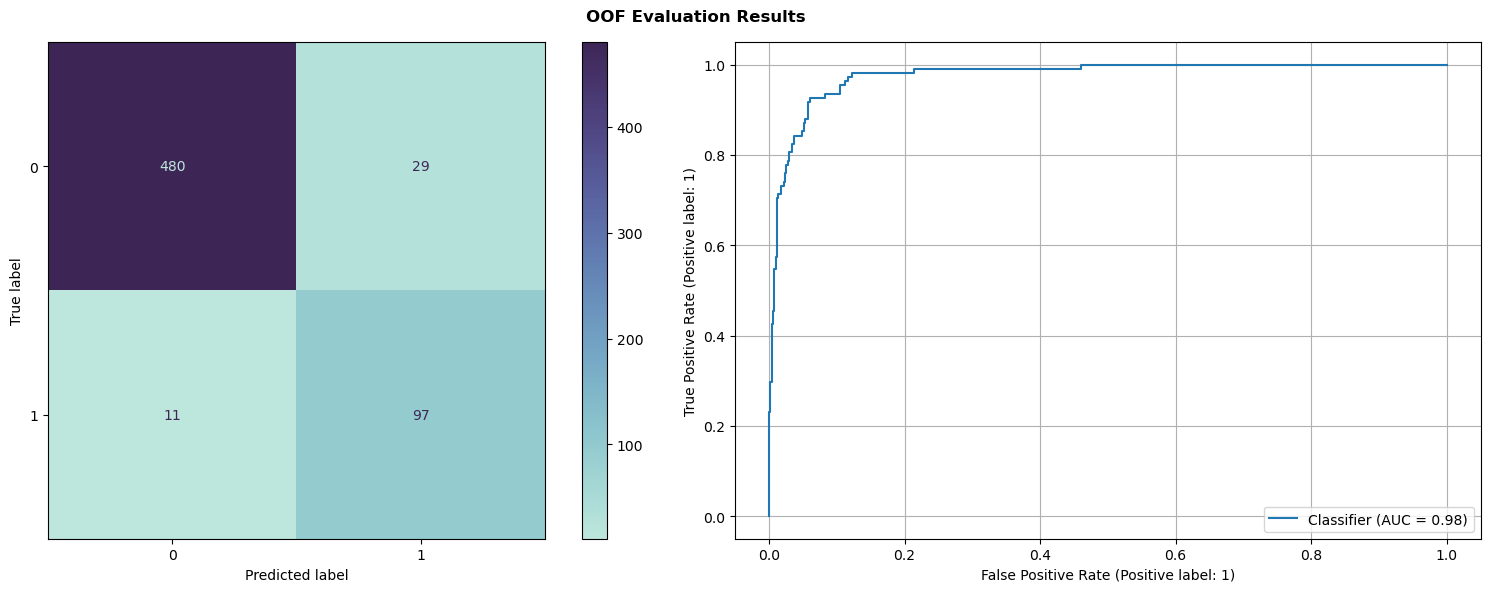

In [20]:
my_palette = sns.cubehelix_palette(n_colors = 7, start=.46, rot=-.45, dark = .2, hue=0.95, as_cmap=True)

def show_confusion_roc(oof, title='Model Evaluation Results'):
    f, ax = plt.subplots(1, 2, figsize=(16, 6))
    df = pd.DataFrame({'preds': oof[0], 'target': oof[1]})
    cm = confusion_matrix(df.target, df.preds.ge(0.5).astype(int))
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap=my_palette, ax=ax[0])
    ax[0].grid(False)
    RocCurveDisplay.from_predictions(df.target, df.preds, ax=ax[1])
    ax[1].grid(True)
    plt.suptitle(f'{title}', fontsize=12, fontweight='bold')
    plt.tight_layout()

show_confusion_roc(oof=[oof_each_predss[:, 0], y_train], title='OOF Evaluation Results')

In [21]:
%%time

stack_test_predss = np.zeros((X_test.shape[0]))
stack_scores = []
stack_models = []
splitter = Splitter(kfold=kfold, n_splits=n_splits, greeks=greeks.iloc[:,1:-1])
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(oof_each_predss, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits
    
    classifier = Classifier(n_estimators, device, random_state_list[m])
    models = classifier.models
    model = models['xgb02']
    
    train_w0, train_w1 = calc_log_loss_weight(y_train_)
    valid_w0, valid_w1 = calc_log_loss_weight(y_val)
    
    model.fit(
    X_train_, y_train_, sample_weight=y_train_.map({0: train_w0, 1: train_w1}),
    eval_set=[(X_val, y_val)],
   # eval_metric='logloss',
    sample_weight_eval_set=[y_val.map({0: valid_w0, 1: valid_w1})],
    early_stopping_rounds=early_stopping_rounds,
    verbose=verbose
)
    
    test_pred = model.predict_proba(test_each_predss)[:, 1].reshape(-1)
    y_val_pred = model.predict_proba(X_val)[:, 1].reshape(-1)

    score = balanced_log_loss(y_val, y_val_pred)
    stack_scores.append(score)
    stack_models.append(deepcopy(model))
    
    stack_test_predss += test_pred / (n_splits * len(random_state_list))

CPU times: user 1min 43s, sys: 1.36 s, total: 1min 45s
Wall time: 26.9 s


In [22]:
# Calculate the mean LogLoss score of the ensemble
mean_score = np.mean(ensemble_score)
std_score = np.std(ensemble_score)
print(f'Ensemble BalancedLogLoss score {mean_score:.5f} ± {std_score:.5f}')
# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')
print('')

# Calculate the mean LogLoss score of the ensemble
mean_score = np.mean(stack_scores)
std_score = np.std(stack_scores)
print(f'Stacking BalancedLogLoss score {mean_score:.5f} ± {std_score:.5f}\n')

Ensemble BalancedLogLoss score 0.20866 ± 0.11022
--- Model Weights ---
xgb01: 0.43866 ± 0.38576
xgb02: 0.42024 ± 0.37584
xgb1: 0.51933 ± 0.42039
xgb2: 0.34485 ± 0.36939
xgb3: 0.13867 ± 0.25829
xgb5: 0.01697 ± 0.02802
svc: 0.02299 ± 0.06742
brf: 0.04891 ± 0.15937

Stacking BalancedLogLoss score 0.13882 ± 0.12605



# <h1 style = "font-family: Georgia;font-weight: bold; font-size: 30px; color: #1192AA; text-align:left">Submission</h1>

In [23]:
sub = pd.read_csv(os.path.join(filepath, 'sample_submission.csv'))

sub['class_1'] = stack_test_predss
sub['class_0'] = 1 - stack_test_predss
sub.to_csv('submission.csv', index=False)
sub

,Id,class_0,class_1
0,00eed32682bb,0.599558,0.400442
1,010ebe33f668,0.599558,0.400442
2,02fa521e1838,0.599558,0.400442
3,040e15f562a2,0.599558,0.400442
4,046e85c7cc7f,0.599558,0.400442
